In [1]:
# Setup Python environment
import numpy as np

# Add files to path
import sys
sys.path.append('../src/')
from potential import GridPotential

# Unit conversions
try:
    from ase.units import Hartree
except ModuleNotFoundError:
    # ASE is not installed -> use hardcoded value
    Hartree = 27.211386024367243

# Notebook magic to ensure
%load_ext autoreload
%autoreload 2

# Configure matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from cycler import cycler

plt.style.use('bmh')
font_size = 14
# Font
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.unicode'] = True
plt.rcParams['font.size'] = font_size
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.sans-serif'] = "Computer Modern"

# X-ticks
plt.rcParams['xtick.labelsize'] = font_size
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 1

# Y-ticks
plt.rcParams['ytick.labelsize'] = font_size
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.width'] = 1

# Axes
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.grid'] = False

# Color cycler
plt.rcParams['axes.prop_cycle'] = cycler('color', ['black', '#b2182b', '#ef8a62', '#fddbc7', '#d1e5f0', '#67a9cf', '#2166ac'])

# Legend
plt.rcParams['legend.facecolor'] = "white"
plt.rcParams['legend.frameon'] = False

In [2]:
# Define helper function plotting potential
def plot_potential(x, data, y=None, levels=None, fig=None, ax=None):
    if levels is None: levels = np.linspace(np.amin(data), np.amax(data), 5)
    
    if fig is None:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
    else:
        if ax is None: ax = fig.gca()

    if y is None or x is None:
        # 1D Plot
        cp = ax.plot(x, data)

    else:
        # 2D Plot
        cp = ax.contourf(x, y, data, levels)
        cb = plt.colorbar(cp)

    return fig, ax, cp

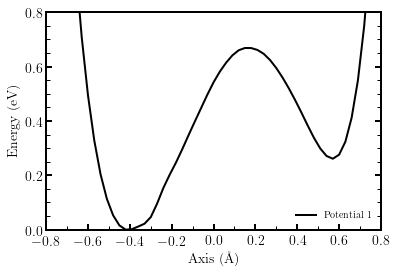

In [3]:
# Read 1D data
fname = 'data/data-1d.txt'
pot = GridPotential(fname, dimension=1)

# Convert data from absolute to relative scale and apply unit conversion (Hartree -> eV)
#minval = pot.global_minimum
pot.absolute_to_relative(unit=Hartree)

# Interpolate potential using default settings
interpolate = True
pot.interpolate()
x, y, data = pot.interpolated_potential

# Create plot
fig, ax, cp = plot_potential(x, data.T)

# Adjust plot appearance
from matplotlib.ticker import AutoMinorLocator
ax.set_axisbelow(False)

ax.set_ylim([-.0,.8])
ax.set_ylabel("Energy (eV)")

ax.set_xlim([-0.8,.8])
ax.set_xlabel("Axis (Å)")
ax.set_xticks(np.arange(-0.8, 1.0, 0.2))

minor_locator = AutoMinorLocator(2)
ax.xaxis.set_minor_locator(minor_locator)

plt.setp(cp, label="Potential 1")
ax.legend()
plt.show()

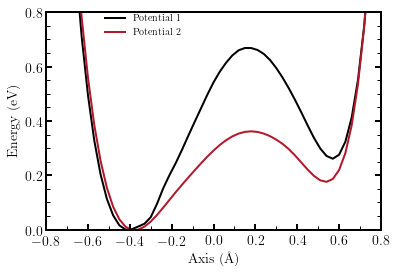

In [4]:
# Lets add a second data set to the figure
fname = 'data/data-1d-2.txt'
pot = GridPotential(fname, dimension=1)
pot.absolute_to_relative(unit=Hartree)
pot.interpolate()
x, y, data = pot.interpolated_potential

# Add new data set to existing plot
fig, ax, cp = plot_potential(x, data.T, fig=fig)
plt.setp(cp, label="Potential 2")
ax.legend(loc='upper left',  bbox_to_anchor=(0.15, 1.03))

# Must call the figure object to display plot (not plt.show() or fig.show())
fig